# Forward modelling of proxy timeseries
In this Tutorial 2, we will apply operators in space and time to model simulation data (`sim_data`). As a result, we will obtain forward modeled proxy time series for selected proxy datasets. Please make sure you are familiar with the contents of Example 1 "Getting Started".

## 0. Preparations

In this tutorial, we will again work with real scientific data. We will use climate model output of transient simulation of the last deglaciation. The simulation was performed with MPI-ESM-CR-1.2 and used the GLAC1D reconstruction as boundary conditions. See the [publication](https://doi.org/10.1029/2021GL096767) for more details. For downloading the netcdf files, use the [wget script](https://github.com/paleovar/cupsm/blob/main/data/wget-mpiesm_simulations_20231208135007.sh) we provided or check out the download possibilities in the dataset [description](https://www.wdc-climate.de/ui/entry?acronym=PMMXMCRTDGP132).

In our example, we will use the simulated sea surface temperature (variable `tos`) over 25000 simulated years. Naturally, the variable comes on an unstructured grid and must be regridded. We recommend regridding with the `xesmf` package. We prepared some code for it, so you can add the absolute file path of one of your example files to the code (`example_file=` in line 27) and simply run the provided piece of code:

```
%run utilities_sst_example.py
```

Then, you can define a regridder and print its properties:

```
regridder = get_regridder()

print(regrider)
```

We then regridded in a straightforward for-loop (change the paths to suit your directory structure):

```
path_deglac='/path/to/your/downloaded/data'
target_path = '/path/to/your/regridded/data'

file_list = [f for f in os.listdir(path_deglac) if f.endswith(".nc")]

for i, file in enumerate(file_list):
    # counter
    if not i % 10: 
        print(f"Interpolating file {i}/{len(file_list)}")
    f = xr.open_dataset(path_deglac+file)
    f_r = regridder(f, skipna=True, na_thres=0.5).tos.to_dataset()
    f_r.attrs["Interpolation"] = "Periodic bilinear interpolation by xESMF Regridder, skipna=True, na_thres=0.5"
    f_r.to_netcdf(target_path+"r_"+file)

```

Now let `xesmf` do its magic. Take a break, grab a coffee or tea. For us, the regridding took about 10 minutes.

As in the first tutorial, the data paths must be defined. You can reuse your `lipd_path` and `table_path` unless you want to use a different proxy data base. The `sim_data_path` is the directory where the regridded netcdf files are.

In [1]:
lipd_path = "/data/obs/proxy_databases/PalMod130k/PALMOD130k_v1_0_1_250320/LiPD/" # path to directory where LiPD files are (only necessary if recreated)
table_path = "/data/projects/nfdi4earth/" # path where the overview table should be stored
sim_data_path = "/data/projects/nfdi4earth/regridded_tos_mpi-esm/" # path where the regridded netcdf files of the simulation data are

Finally, import the required packages.

In [2]:
# import packages
import pandas as pd
import numpy as np
import xarray as xr

# import cupsm
# since cupsm is only available on GitHub, 
# you need to expand your python path variable 
# to the code directory for this notbook session
import sys
sys.path.append('../') # here, it will be the parent direcory
import cupsm
# import a function from the tutorial code bits
from tutorials.utilities_sst_example import transfer_timeaxis_deglac

# import plotting packages
import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

In [2]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

## 1. Initialize obs_data
**as dictionary, keys are the site names and values the site_objects**


Here, we reuse the code of the Tutorial 1.

In [3]:
# load the overview table
proxy_overview_table = cupsm.create_proxy_info(database_path=lipd_path, save_path=table_path)

# specify example sites
sites = ["SU81_18.lpd", "TR163_22.lpd", "SO201_2_12KL.lpd", "MD98_2181.lpd", "GeoB1711_4.lpd"]

# get the obs_data object
obs_data = cupsm.get_records_df(df=proxy_overview_table, file_name=sites, return_as="dictionary")

The .proxy_meta_data.pkl file is already present in /data/projects/nfdi4earth/ and is returned.
For updating the file, run with the update=True
I return a dictionary with 5 record objects at None +/- None.


## 2. Initialize sim_data
**as chunked xarray DataArray**

Here, we use xarray's `open_mfdataset` function which allows to load multiple files as a single dataset. The keyword `parallel=True` enables parallelized file opening using dask. For us, opening 25000 years of simulation data took about 9 seconds. 

In [11]:
sim_data = xr.open_mfdataset(f"{sim_data_path}*.nc", parallel=True, use_cftime=True,)

sim_data

<xarray.Dataset>
Dimensions:  (time: 300000, lat: 101, lon: 122)
Coordinates:
  * time     (time) object 0001-01-16 12:00:00 ... 25000-12-16 12:00:00
  * lat      (lat) float64 -90.0 -88.2 -86.4 -84.6 -82.8 ... 84.6 86.4 88.2 90.0
  * lon      (lon) float64 -180.0 -177.0 -174.1 -171.1 ... 171.1 174.1 177.0
Data variables:
    tos      (time, lat, lon) float64 dask.array<chunksize=(1200, 101, 122), meta=np.ndarray>
Attributes:
    Interpolation:  Periodic bilinear interpolation by xESMF Regridder, skipn...

Our sim_data contains the variable `tos` on monthly resolution (300000 time steps) and the time axis goes from January in year 0001 to December in year 25000. In the imports, a function `transfer_timeaxis_deglac` is imported from the `utilities_sst_example.py`. This transfers the time axis of the simulation data. Now, it covers the timespan of 25 kiloyears before present to 0 kiloyears before present and is therefore in tune with the time axis of the proxy data base. 

**NOTE:** This is not a general function but very specific to our example. If you use your own model output, make sure that the time axis is correctly defined and contains `cftime.Datetime` objects.

In [12]:
# apply the time axis transformation and chose our variable `tos`
sim_data = transfer_timeaxis_deglac(sim_data.tos)

Now, since we chose the variable, we now have a chunked xarray DataArray named `tos`:

In [6]:
sim_data

<xarray.DataArray 'tos' (time: 300000, lat: 101, lon: 122)>
dask.array<concatenate, shape=(300000, 101, 122), dtype=float64, chunksize=(1200, 101, 122), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -88.2 -86.4 -84.6 -82.8 ... 84.6 86.4 88.2 90.0
  * lon      (lon) float64 -180.0 -177.0 -174.1 -171.1 ... 171.1 174.1 177.0
  * time     (time) object 25000-01-16 12:00:00 ... 0001-12-16 12:00:00

## 3. Initialize target object
**as dictionary of python class objects, keys are the site_names**

If you have already worked with proxy data, you'll know that it's all about the details! To define target objects for the chosen obs_data, we need to know more about our proxies.

Let's load the proxy data and hava a look at the available datasets.

In [4]:
# load the data, quiet=True suppresses diagnostic print outs and save_in_object saves the xarray
# DataSet in the data attribute: site_object.data

for i,site_object in enumerate(obs_data.values()):
    site_object.load_paleo_data("all", save_in_object=True, quiet=True)

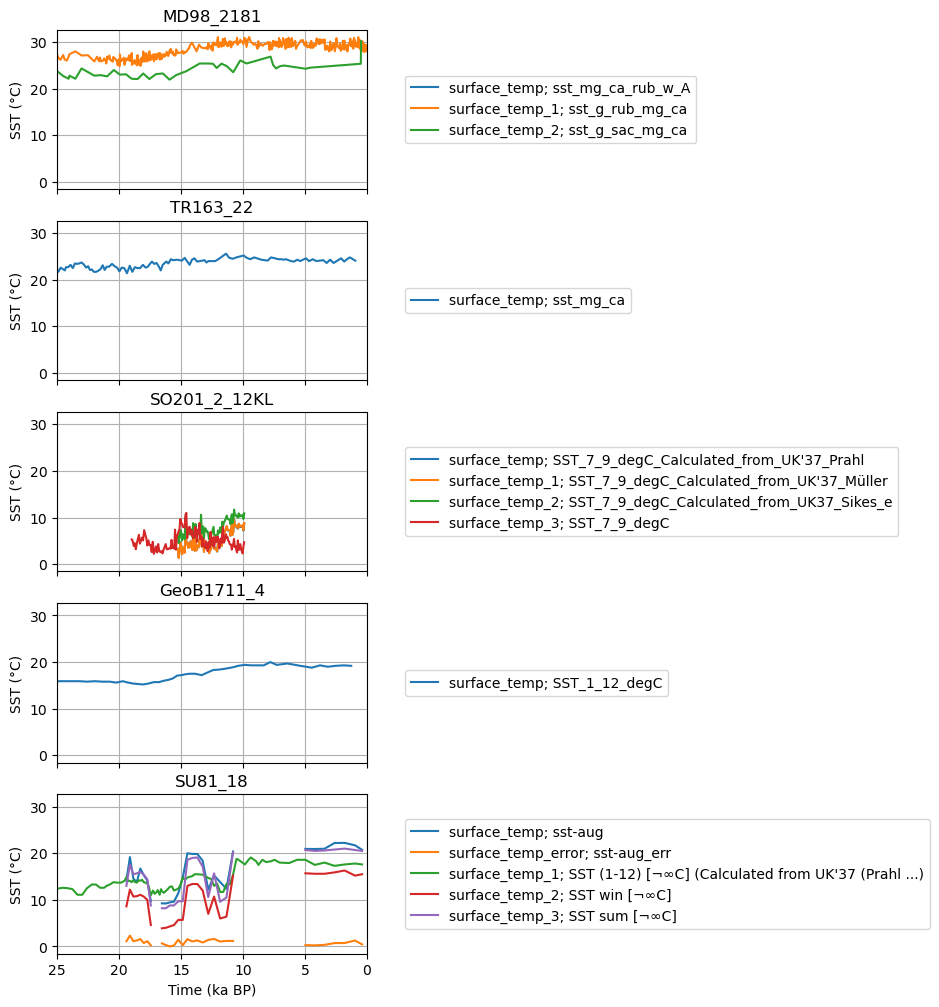

In [5]:
# plot temperature data for the five sites
fig, axes = plt.subplots(5,1, figsize=(4,12), sharex=True, sharey=True)
axes = axes.flatten()

# iterate through site_objects, one plot for one object
for i,site_object in enumerate(obs_data.values()):
    a = axes[i]
    a.set_title(site_object.site_name)
    
    # create a list of available variables with the keyword "temp" in them
    temp_variables = [var for var in site_object.data.variables if "temp" in var]

    # iterate through available variables
    for var in temp_variables:
        mask = ~np.isnan(site_object.data[var])
        a.plot(site_object.data.age[mask], site_object.data[var][mask], label=f"{var}; {site_object.data[var].description}")
    a.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
    a.grid()
    a.set_xlim(25,0)
    a.set_ylabel("SST (°C)")

axes[-1].set_xlabel("Time (ka BP)")
plt.show()

There are indeed some details to explore! For three of the five records, there are multiple datasets of palaeotemperature measurements. Now, some subjective choices must be  

The target object creator accepts following keywords:
    - 
    - record_var:     string; the variable name of the paleo dataset
    - sim_var:        string; the variable name of the simulation dataset
    - habitatSeason:  string; valid keywords are "summer", "winter" or "annual". Refers to the local season (e.g. austral summer is summer).
    - month_i:        list of integers; indices of the month for which the paleo data are representative (for example, for boreal summer temperatures, month_i could be [7,8,9] for samples taken in July, August and September).

In [2]:
mapping_vars = {"MD98_2181": "surface_temp_1", # orange line
                "TR163_22": "surface_temp", # blue line
                "SO201_2_12KL": "surface_temp_3", # red line
                "GeoB1711_4": "surface_temp", # blue line
                "SU81_18": "surface_temp_1", # green line
               }

mapping_season = {"MD98_2181": "annual", # assume annual, since no further information available
                "TR163_22": "annual", # assume annual, since no further information available
                "SO201_2_12KL": [7,8,9], # put 7,8,9 as list of integers, since month 7-9 are given in description
                "GeoB1711_4": "annual", # assume annual, since month 1-12 are given
                "SU81_18": "annual",  # assume annual, since month 1-12 are given
               }

In [3]:
# initialize target objects in a for loop

for i,site_object in enumerate(obs_data.values()):
    
    # set variable names and season
    record_variable = mapping_vars[site_object.site_name]
    simulation_variable = "tos"
    habitat_season = mapping_season[site_object.site_name]
    
    # intializes target object
    site_object.create_target(record_var=record_variable, sim_var=simulation_variable, habitatSeason=habitat_season)


In [10]:
# Now one can access the target via the site_object:

example_site = "GeoB1711_4"

print(f"For site {example_site}, the habitat season is {obs_data[example_site].target.habitatSeason}.")

For site GeoB1711_4, the habitat season is annual.


## 4. Apply operators
- sequential, first space, then time

### 4.1 Space operator
- demonstrate map
- compute before time!

In [ ]:
# test space

### 4.2 Chron operator
- show difference of in pointing mnethods, maybe graphic for sampling method

## 4.3 Apply for obs_data

In [ ]:
# apply all operators


sim_data2site = cupsm.field2site(sim_data, , radius_km=300)

In [ ]:
# compute



## 5. Plot results

## DEbugging at its best


In [1]:
lipd_path = "/data/obs/proxy_databases/PalMod130k/PALMOD130k_v1_0_1_250320/LiPD/" # path to directory where LiPD files are (only necessary if recreated)
table_path = "/data/projects/nfdi4earth/" # path where the overview table should be stored
sim_data_path = "/data/projects/nfdi4earth/regridded_tos_mpi-esm/" # path where the regridded netcdf files of the simulation data are

# import packages
import pandas as pd
import numpy as np
import xarray as xr

# import cupsm
# since cupsm is only available on GitHub, 
# you need to expand your python path variable 
# to the code directory for this notbook session
import sys
sys.path.append('../') # here, it will be the parent direcory
import cupsm
# import a function from the tutorial code bits
from tutorials.utilities_sst_example import transfer_timeaxis_deglac

# import plotting packages
import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

# load the overview table
proxy_overview_table = cupsm.create_proxy_info(database_path=lipd_path, save_path=table_path)

# specify example sites
sites = ["SU81_18.lpd", "TR163_22.lpd", "SO201_2_12KL.lpd", "MD98_2181.lpd", "GeoB1711_4.lpd"]

# get the obs_data object
obs_data = cupsm.get_records_df(df=proxy_overview_table, file_name=sites, return_as="dictionary")

The .proxy_meta_data.pkl file is already present in /data/projects/nfdi4earth/ and is returned.
For updating the file, run with the update=True
I return a dictionary with 5 record objects at None +/- None.


In [6]:
test_obj = cupsm.get_records_df(df=proxy_overview_table, file_name="MD95_2039.lpd")

Exception: Got exception: <class 'TypeError'> lipd2object.__init__() got an unexpected keyword argument 'file_name' <traceback object at 0x75aaf7e57f80>